<center>

<h1 style="font-size: 40px;">Bayesian Model</h1>

</center>


The goal of this exercise is to implement an inference tool using Bayesian networks and demonstrate its capabilities using an example with the alarm network showed below. Here are the assumptions:
1. Inference will use the MCMC algorithm with Gibbs sampling.
2. The inference method/function will have three input parameters:
   - Evidence (observed values of selected network nodes).
   - Query (specifying which variable we want to compute).
   - Number of MCMC iterations.
   - The function will return an updated probability table for the queried variable.
3. We can assume that all random variables are binary.
4. Experiments should explore how inference results and computation time change with increasing iterations.

We set the initial probabilities according to the assumptions:

\begin{aligned}
&\begin{array}{ll|l}
\text { BR } & \text { EQ } & P(\text { Alarm } \mid W, T) \\
\hline 1 & 1 & 0.95 \\
1 & 0 & 0.94 \\
0 & 1 & 0.29 \\
0 & 0 & 0.001
\end{array}\\
&\begin{array}{l|lll|l}
\text { Alarm } & P(J \mid A) & & \text { Alarm } & P(M \mid A) \\
\hline 1 & 0.90 & & 1 & 0.70 \\
0 & 0.05 & & 0 & 0.01
\end{array}
\end{aligned}

In [1]:
probabilities = {
    'Burglary': {None: 0.01},
    'Earthquake': {None: 0.02},
    "Alarm": {(True, True): 0.95, (True, False): 0.94, (False, True): 0.29, (False, False): 0.001},
    "JohnCalls": {(True,): 0.90, (False,): 0.05},
    "MaryCalls": {(True,): 0.70, (False,): 0.01}
}
graph = {
    'Burglary': [],
    'Earthquake': [],
    'Alarm': ['Burglary', 'Earthquake'],
    'JohnCalls': ['Alarm'],
    'MaryCalls': ['Alarm']
}

In [ ]:
%pip install matplotlib
%pip install pandas

import random
import time
import matplotlib.pyplot as plt
import pandas as pd

<b>Markov Chain Monte Carlo Sampling</b><br>
For every random $x_j ∈ \{x_1, x_2, . . .\} $ in X calculate:

\begin{equation}
P\left(X=x_j \mid O M(X)\right)=\alpha P\left(X=x_j \mid \operatorname{Parent}(X)\right) \prod_{Z_i \in Children(X)} P\left(Z_i=z_i \mid \operatorname{Parent}\left(Z_i\right)\right),
\end{equation}

Where:
- Parents($\cdot$) and Children($\cdot$) - refer to the sets of parents/children for a given node (random variable) with fixed values.
- We assume that we know the values $Z_i=z_i$ for all variables $Z_i$ in the Markov blanket.
- Each time, we set the value $X=x_j$ in the network, meaning that $\left(X=x_j\right) \in \operatorname{Parents}\left(Z_i\right)$.
- $\alpha$ - the normalization coefficient, which we can calculate using the fact that $\sum_x P(X=x \mid \operatorname{Parents}(X))=$ 1.

In [3]:
class BayesianModel:
    def __init__(self, probabilities, graph):
        self.probabilities = probabilities
        self.graph = graph

    def get_parents(self, node):
        return self.graph[node]

    def get_children(self, node):
        children = []
        for child, parents in self.graph.items():
            if node in parents:
                children.append(child)
        return children

    def calculate_conditional_probability(self, node, state):
        parents = self.get_parents(node)
        parents_states = tuple(state[parent] for parent in parents)

        if parents:
            conditional_prob = self.probabilities[node][parents_states] if state[node] else 1 - self.probabilities[node][parents_states]
        else:
            conditional_prob = self.probabilities[node][None] if state[node] else 1 - self.probabilities[node][None]

        children = self.get_children(node)
        children_prob_product = 1
        for child in children:
            child_parents = self.get_parents(child)
            child_parents_states = tuple(state[parent] for parent in child_parents)
            child_state = state[child]

            children_prob_product *= self.probabilities[child][child_parents_states] if child_state else 1 - self.probabilities[child][child_parents_states]

        return conditional_prob * children_prob_product

    def sample_from_markov_blanket(self, node, state):
        state[node] = True
        true_prob = self.calculate_conditional_probability(node, state)
        state[node] = False
        false_prob = self.calculate_conditional_probability(node, state)
        node_value = random.choices([True, False], weights=[true_prob, false_prob])[0]
        return node_value

    def gibbs_sampling(self, evidences, question, iterations):
        st = time.time()

        variables = list(self.graph.keys())
        state = {node: random.choice([True, False]) for node in variables if node not in evidences}
        state.update(evidences)

        counts = {True: 0, False: 0}
        no_evidence_nodes = set(variables) - set(evidences.keys())

        for _ in range(iterations):
            random_node = random.choice(list(no_evidence_nodes))
            state[random_node] = self.sample_from_markov_blanket(random_node, state)
            counts[state[question]] += 1

        normalized_counts = {k: v/iterations for k, v in counts.items()}

        et = time.time()
        elapsed_time = et - st

        return normalized_counts, elapsed_time

In [4]:
bn = BayesianModel(probabilities, graph)

In [5]:
def plot_prob_time(evidences, question, iterations, if_log=False, title=None):
    probabilities = []
    times = []
    for i in iterations:

        probability, et = bn.gibbs_sampling(evidences, question, i)
        probabilities.append(probability[True])
        times.append(et)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    if if_log:
        axes[0].set_xscale('log')
    axes[0].plot(iterations, probabilities)
    axes[0].set_xlabel('iterations')
    axes[0].set_ylabel('probability')
    axes[0].set_title(title)


    if if_log:
        axes[1].set_xscale('log')
    axes[1].plot(iterations, times)
    axes[1].set_xlabel('iterations')
    axes[1].set_ylabel('time')
    axes[1].set_title(title)


    plt.tight_layout()
    plt.show()

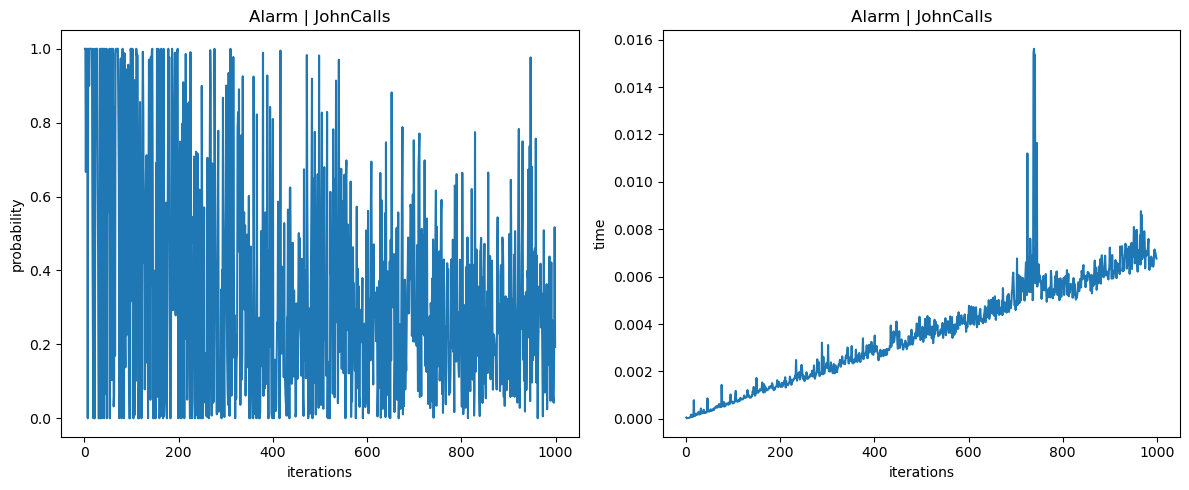

In [6]:
iterations = [x for x in range(1, 1000, 1)]

evidences = { 'JohnCalls': True}
question = 'Alarm'

plot_prob_time(evidences, question, iterations, title='Alarm | JohnCalls')

We observe that after 1000 iterations for a given query, we still cannot achieve a stable result.

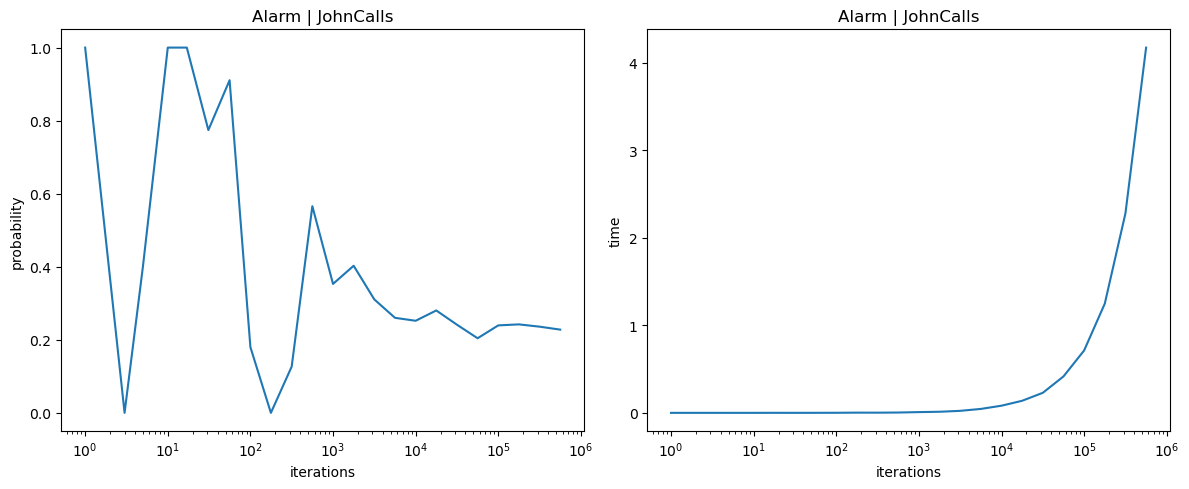

In [7]:
iterations = [int(10**(0.25*x)) for x in range(1, 24, 1)]

evidences = { 'JohnCalls': True}
question = 'Alarm'

plot_prob_time(evidences, question, iterations, if_log=True, title='Alarm | JohnCalls')

As we can observe, achieving a reasonably stable result typically requires several thousand iterations.

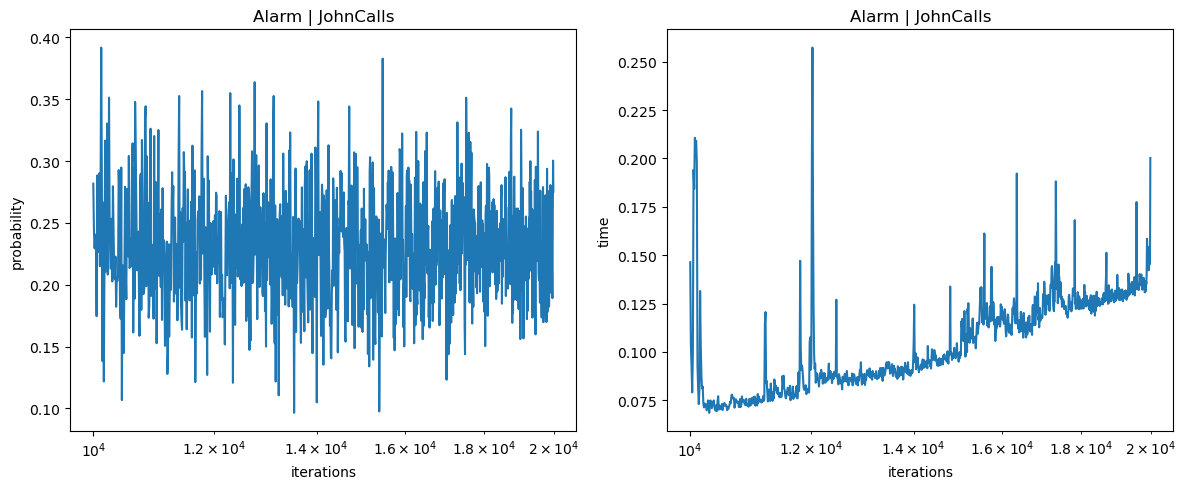

In [8]:
iterations = [x+10000 for x in range(1, 10000, 10)]

evidences = { 'JohnCalls': True}
question = 'Alarm'

plot_prob_time(evidences, question, iterations, if_log=True, title='Alarm | JohnCalls')

Even after 10,000 iterations, the probability remains unstable, making precise determination challenging. Therefore, I decided to calculate the mean and standard deviation.

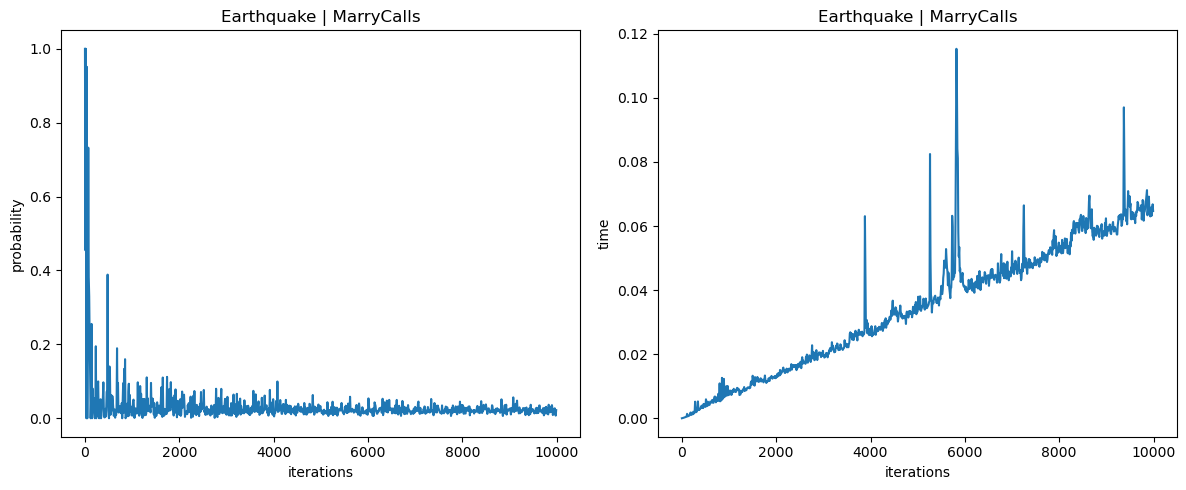

In [9]:
iterations = [x for x in range(1, 10000, 10)]

evidences = { 'MarryCalls': True}
question = 'Earthquake'

plot_prob_time(evidences, question, iterations, title='Earthquake | MarryCalls')

The time increases linearly.

In [10]:
happenings = ['Burglary', 'Earthquake', 'Alarm', 'JohnCalls', 'MaryCalls']

df = pd.DataFrame(columns=happenings, index=happenings)

for evidence in happenings:
    for question in happenings:
        probabilities = []

        for i in range(100):
            probability, et = bn.gibbs_sampling({evidence: True}, question, 10000)
            probabilities.append(probability[True])

        avg = sum(probabilities) / len(probabilities)
        std = (sum((x - avg) ** 2 for x in probabilities) / len(probabilities)) ** 0.5
        df.at[question, evidence] = f'{avg:.2f} ± {std:.2f}'

df = df.rename_axis(index='Question', columns='Evidence')
df


Evidence,Burglary,Earthquake,Alarm,JohnCalls,MaryCalls
Question,,,,,
Burglary,1.00 ± 0.00,0.01 ± 0.00,0.59 ± 0.03,0.13 ± 0.04,0.31 ± 0.05
Earthquake,0.02 ± 0.00,1.00 ± 0.00,0.36 ± 0.04,0.10 ± 0.02,0.21 ± 0.03
Alarm,0.94 ± 0.01,0.30 ± 0.04,1.00 ± 0.00,0.22 ± 0.05,0.52 ± 0.07
JohnCalls,0.85 ± 0.01,0.30 ± 0.04,0.90 ± 0.01,1.00 ± 0.00,0.50 ± 0.06
MaryCalls,0.66 ± 0.02,0.22 ± 0.03,0.70 ± 0.01,0.17 ± 0.04,1.00 ± 0.00


Testing with more proofs.

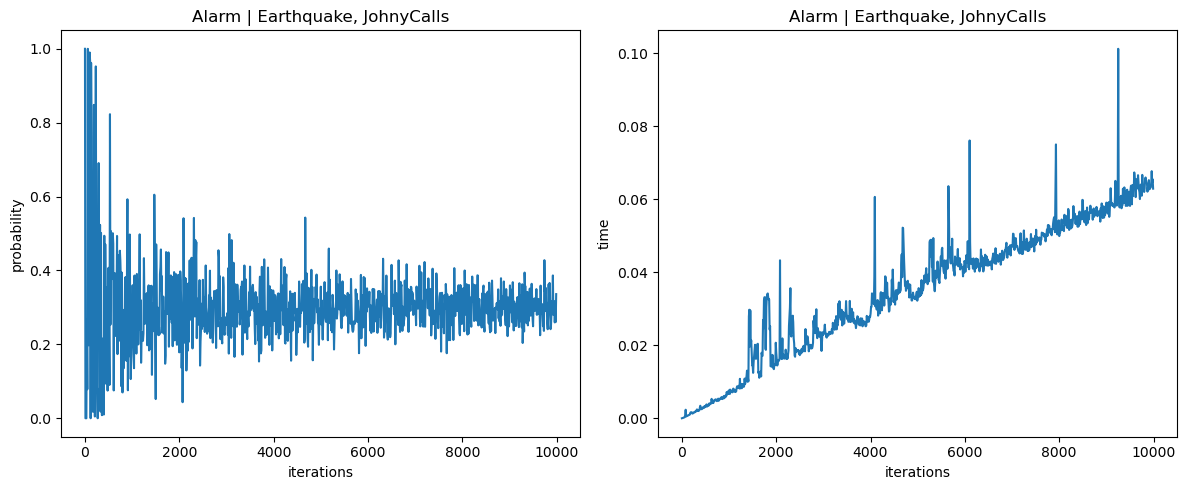

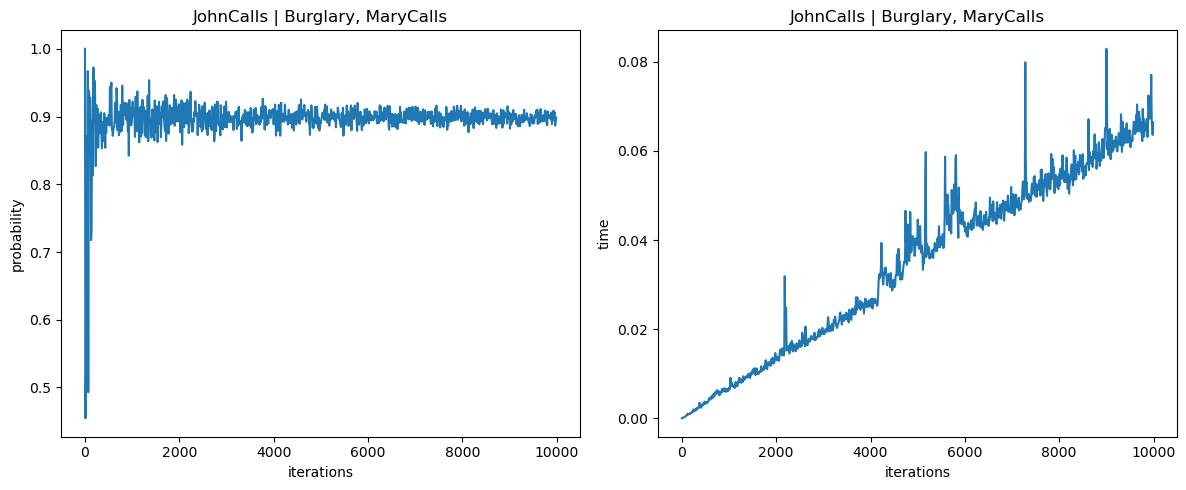

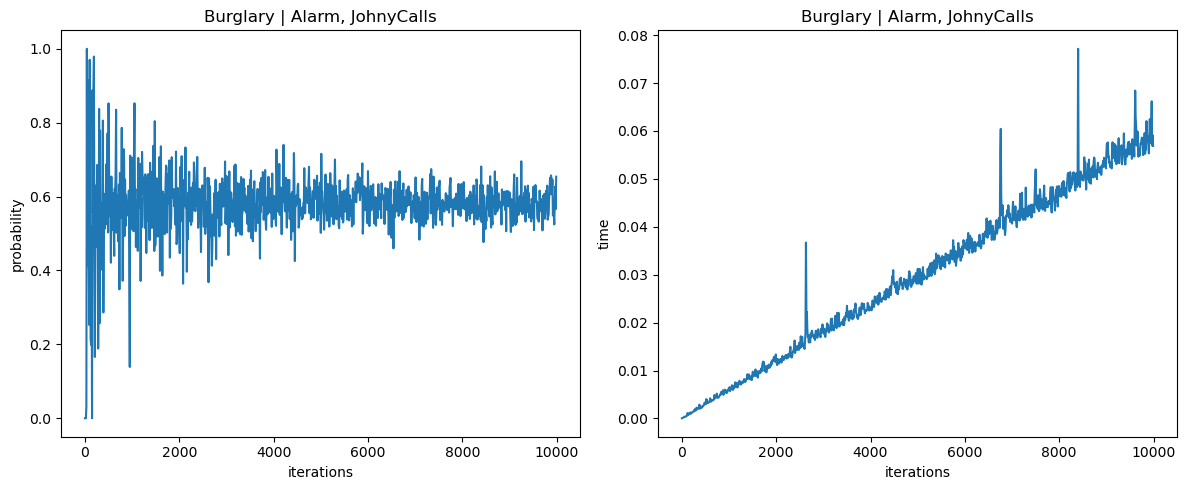

In [11]:
evidences = { 'Earthquake': True, 'JohnyCalls': True }
question = 'Alarm'
iterations = [x for x in range(1, 10000, 10)]
plot_prob_time(evidences, question, iterations, title='Alarm | Earthquake, JohnyCalls')

evidences = { 'Burglary': True, 'MaryCalls': True }
question = 'JohnCalls'
iterations = [x for x in range(1, 10000, 10)]
plot_prob_time(evidences, question, iterations, title='JohnCalls | Burglary, MaryCalls')

evidences = { 'Alarm': True, 'JohnyCalls': True }
question = 'Burglary'
iterations = [x for x in range(1, 10000, 10)]
plot_prob_time(evidences, question, iterations, title='Burglary | Alarm, JohnyCalls')

Achieving reasonably stable results often requires several thousand iterations. Additionally, the time spent on the process increases linearly.

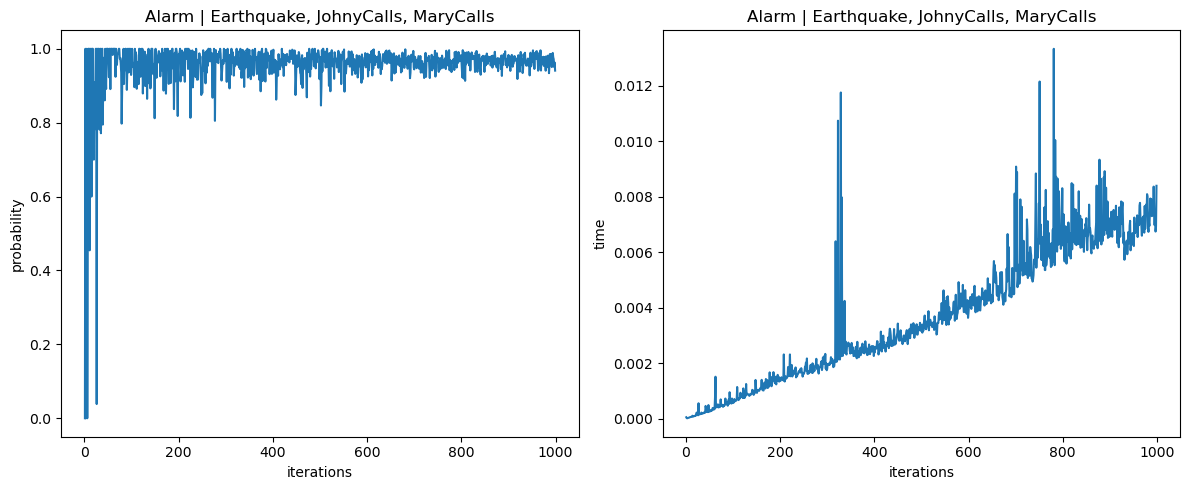

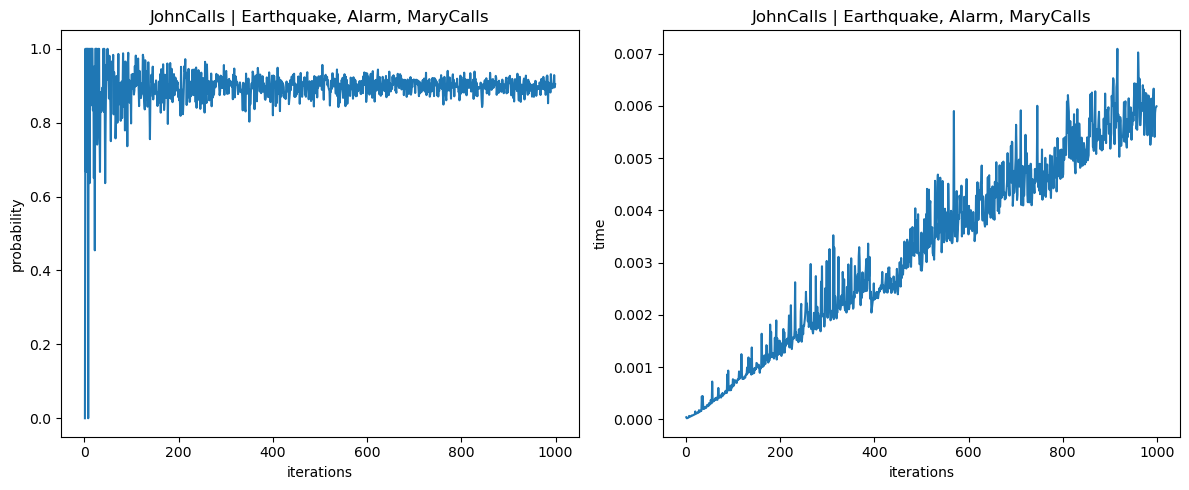

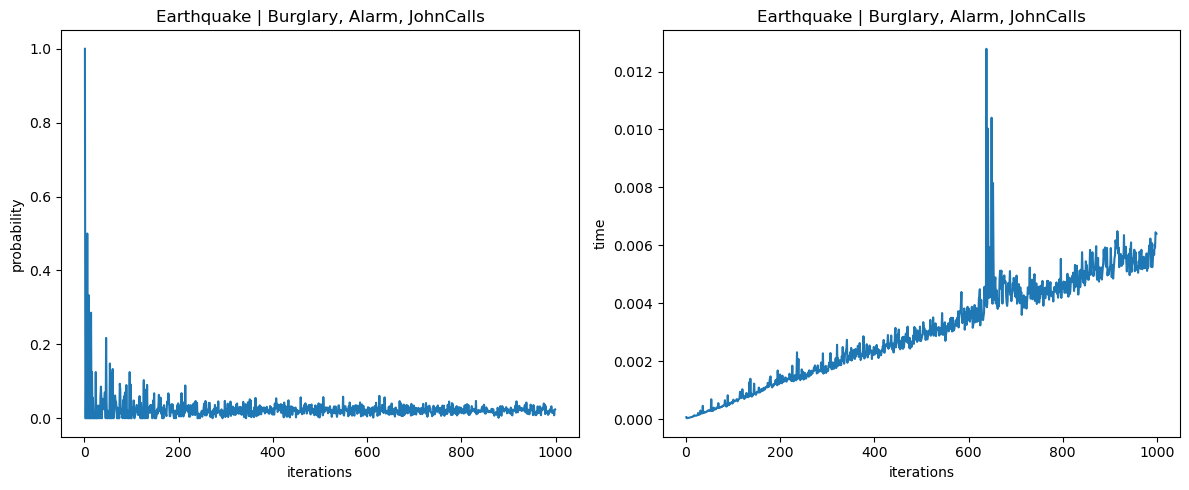

In [12]:
evidences = { 'Earthquake': True, 'JohnyCalls': True, 'MaryCalls': True }
question = 'Alarm'
iterations = [x for x in range(1, 1000, 1)]
plot_prob_time(evidences, question, iterations, title='Alarm | Earthquake, JohnyCalls, MaryCalls')

evidences = { 'Earthquake': True, 'Alarm': True, 'MaryCalls': True }
question = 'JohnCalls'
iterations = [x for x in range(1, 1000, 1)]
plot_prob_time(evidences, question, iterations, title='JohnCalls | Earthquake, Alarm, MaryCalls')

evidences = { 'Burglary': True, 'Alarm': True, 'JohnCalls': True }
question = 'Earthquake'
iterations = [x for x in range(1, 1000, 1)]
plot_prob_time(evidences, question, iterations, title='Earthquake | Burglary, Alarm, JohnCalls')

In the case of 3 pieces of evidence, we achieve stable results much faster.

We can conclude that the more evidence we provide, the faster we reach the expected probability value.